<h1 align='center'> <b>Corrosion Detection with YOLO and Segment Anything Model</b></h1>

## STEP 1 : Installations, downloads & Imports

Links :
1. https://learnopencv.com/ultralytics-yolov8/

In [ ]:
### Installations
!pip install ultralytics -q
!pip install supervision -q
!pip install 'git+https://github.com/facebookresearch/segment-anything.git' -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.6/599.6 kB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
### Imports
import os
import cv2
import torch
import warnings
import numpy as np
from PIL import Image
import tensorflow as tf
import supervision as sv
from ultralytics import YOLO
from google.colab import drive
warnings.filterwarnings('ignore')
import IPython.display as display
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

In [ ]:
### Mounting Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection"
%mkdir '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/SAM_Weights'
%cd '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/SAM_Weights'
%pwd

In [ ]:
### Downloading .pth file from segment anaything model
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## STEP 2 : Model Training

In [ ]:
%cd "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection"

/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection


In [ ]:
%%time
data_path = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/data.yaml'
model_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/yolov8n.pt"
model = YOLO(model_path)

GPU_name=tf.config.list_physical_devices('GPU')[0].name[17:]
with tf.device(device_name=GPU_name):
    model_history = model.train(data = data_path, epochs=200, imgsz=224, plots=True, batch=64, lr0=0.01, dropout=0.1, patience = 100)

Ultralytics YOLOv8.0.116 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/yolov8n.pt, data=/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/data.yaml, epochs=200, patience=100, batch=64, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.1, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=Fa

CPU times: user 6min 15s, sys: 29.4 s, total: 6min 44s
Wall time: 14min 4s


## STEP 3 : Visualize the model's performance

In [1]:
# display.Image(filename = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/runs/detect/train6/confusion_matrix.png', width=600)

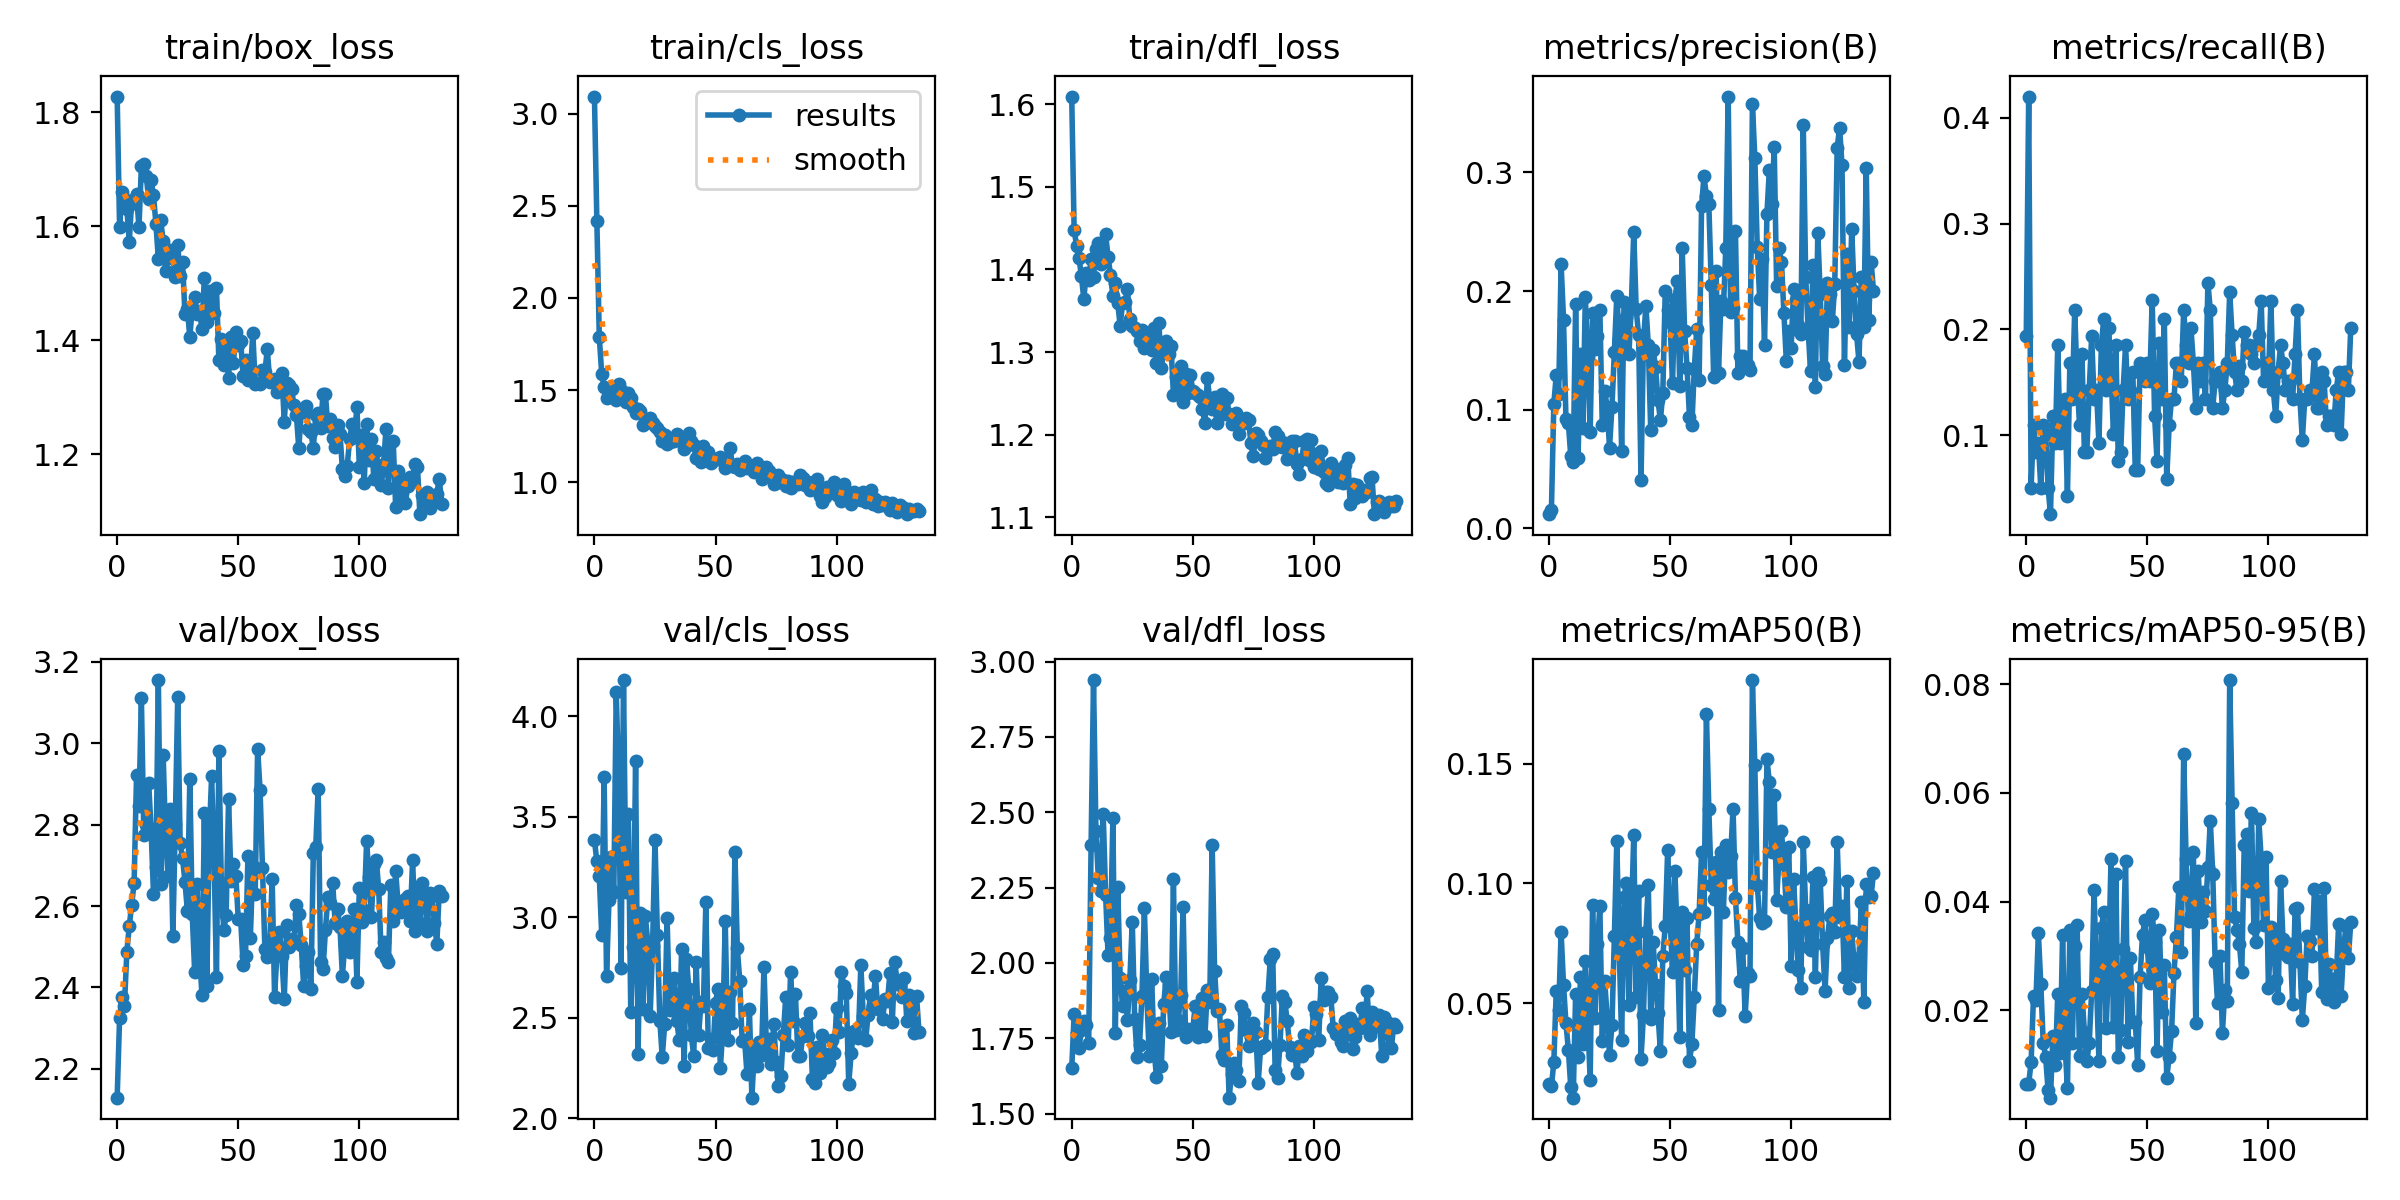

In [ ]:
display.Image(filename = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/runs/detect/train6/results.png', width=600)

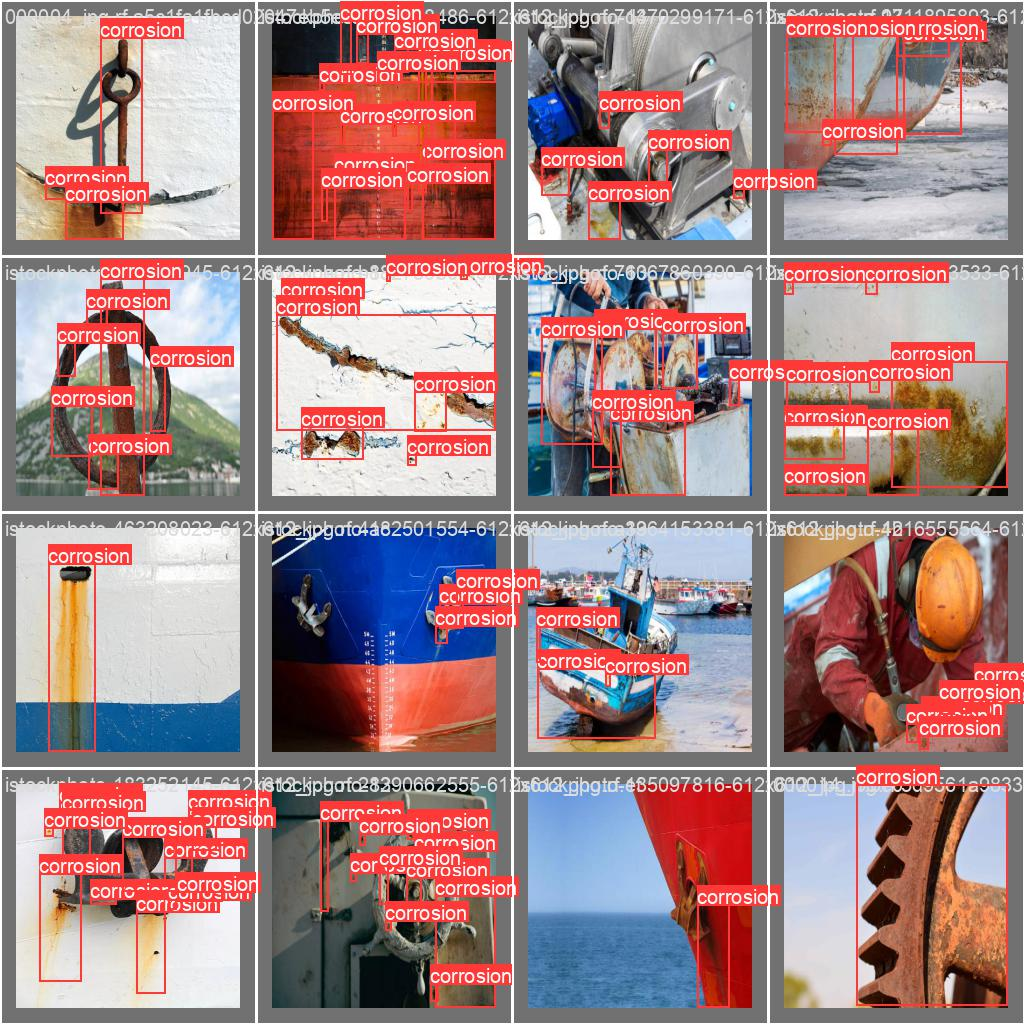

In [ ]:
display.Image(filename = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/runs/detect/train6/val_batch0_labels.jpg', width = 600)

## STEP 4 : Using segment anything model

In [ ]:
class Mask:
    def __init__(self, image_path):
        self.image = cv2.cvtColor(np.array(Image.open(image_path)), cv2.COLOR_BGR2RGB)
        self.yolo_model = YOLO('/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/runs/detect/train2/weights/best.pt')
        self.DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.MODEL_TYPE = "vit_h"
        self.CHECKPOINT_PATH = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/SAM_Weights/sam_vit_h_4b8939.pth'

    def extract_bounding_box(self):
        result = self.yolo_model.predict(source=self.image, augment=True, iou=0.8, conf=0.3,show_labels=False)[0]
        boxes = result.boxes.xyxy
        confs = result.boxes.conf
        box_classes = result.boxes.cls.cpu().numpy()

        return boxes, confs,box_classes


    def get_masked_image(self):
        boxes, confs, boxes_class = self.extract_bounding_box()
        sam = sam_model_registry[self.MODEL_TYPE](checkpoint=self.CHECKPOINT_PATH).to(device=self.DEVICE)
        mask_predictor = SamPredictor(sam)
        segmented_image = self.image.copy()
        box_image = self.image.copy()
        boxes_class_value = {'0':sv.Color.green()}
        mask_predictor.set_image(self.image)

        torch.use_deterministic_algorithms(False)
        masks, scores, logits = mask_predictor.predict_torch(
            point_coords = None,
            point_labels = None,
            boxes = boxes * 1040/max(self.image.shape),
            multimask_output=True,
        )

        masks = masks.cpu().numpy()
        i = 0

        for box in boxes.cpu().numpy():

            box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
            mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

            detections = sv.Detections(xyxy=sv.mask_to_xyxy(masks=masks[i]),mask=masks[i])

            detections = detections[detections.area == np.max(detections.area)]
            box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
            segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)
            i += 1

        sv.plot_images_grid(images=[self.image,box_image, segmented_image],
        grid_size=(1, 3),titles=['source image','box image','segmented image'])





0: 224x224 4 corrosions, 118.1ms
Speed: 1.3ms preprocess, 118.1ms inference, 2.1ms postprocess per image at shape (1, 3, 224, 224)


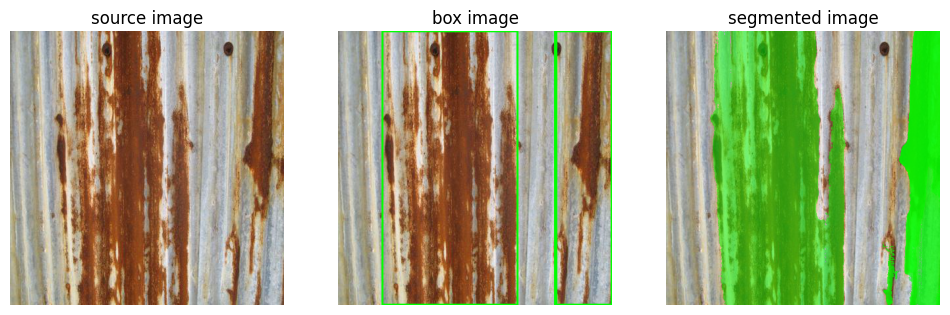

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "000007_jpg.rf.52dba01fbe1666603b6137b08b3f35d6.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 224x224 4 corrosions, 129.2ms
Speed: 11.2ms preprocess, 129.2ms inference, 13.8ms postprocess per image at shape (1, 3, 224, 224)


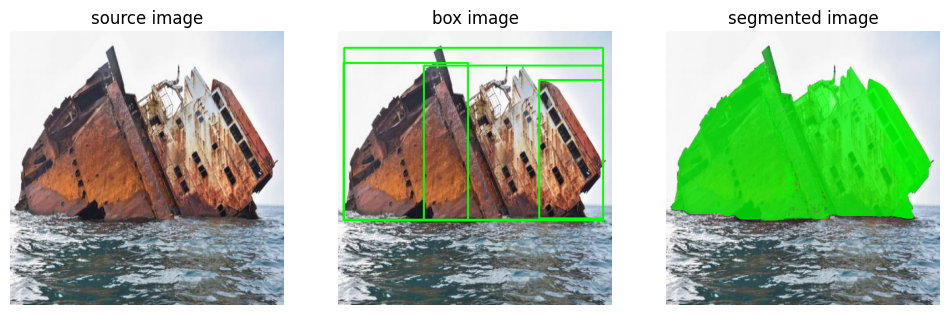

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "istockphoto-1388408054-612x612_jpg.rf.0f40dc2bfc84c4c181d526a0fe1f659e.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 160x224 2 corrosions, 32.9ms
Speed: 8.8ms preprocess, 32.9ms inference, 8.3ms postprocess per image at shape (1, 3, 224, 224)


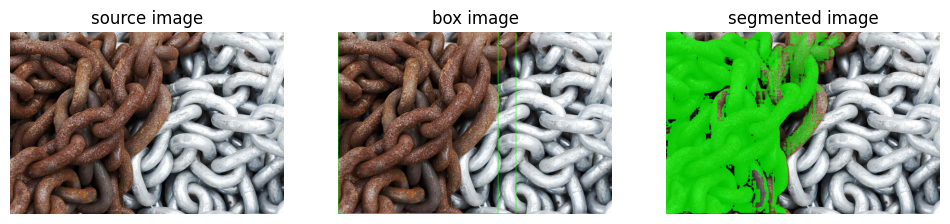

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "test_1.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 128x224 1 corrosion, 21.8ms
Speed: 6.6ms preprocess, 21.8ms inference, 7.2ms postprocess per image at shape (1, 3, 224, 224)


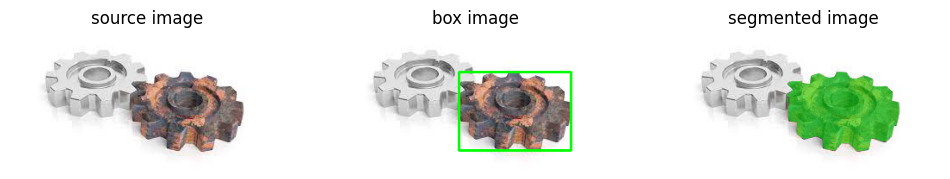

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name ="test_10.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 160x224 3 corrosions, 22.0ms
Speed: 6.7ms preprocess, 22.0ms inference, 8.6ms postprocess per image at shape (1, 3, 224, 224)


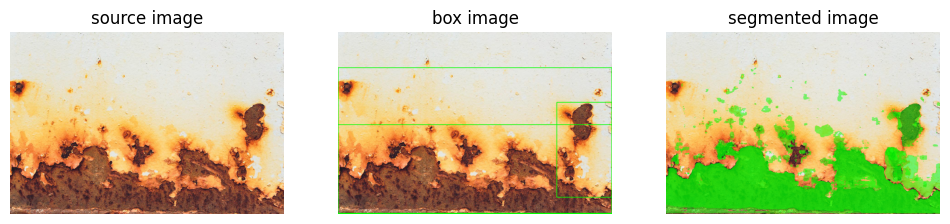

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "test_2.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 128x224 3 corrosions, 169.6ms
Speed: 6.8ms preprocess, 169.6ms inference, 5.3ms postprocess per image at shape (1, 3, 224, 224)


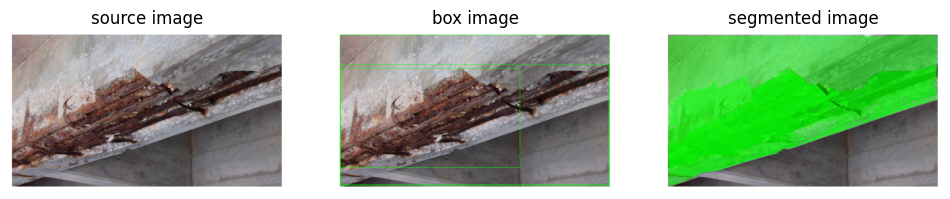

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "test_9.png"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 224x224 3 corrosions, 27.4ms
Speed: 6.9ms preprocess, 27.4ms inference, 7.7ms postprocess per image at shape (1, 3, 224, 224)


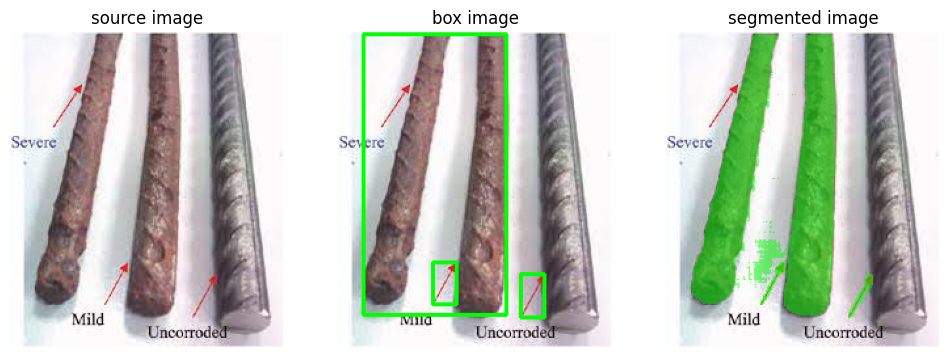

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "test_6.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot


0: 160x224 4 corrosions, 186.9ms
Speed: 7.0ms preprocess, 186.9ms inference, 5.2ms postprocess per image at shape (1, 3, 224, 224)


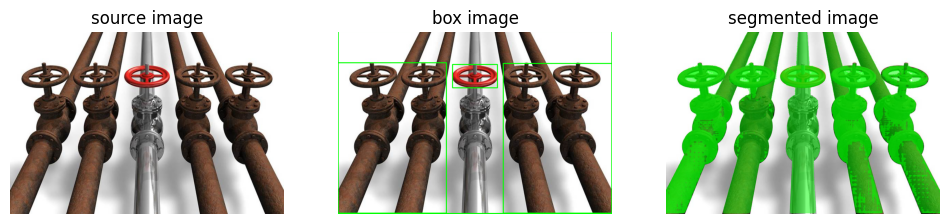

In [ ]:
root_path = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/"
image_name = "test_5.jpg"
image_path = os.path.join(root_path, image_name )

plot = Mask(image_path).get_masked_image()
plot

##### Rough : Individual operation execution

In [ ]:
yolo_model = YOLO('/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/runs/detect/train6/weights/best.pt')

In [ ]:
### Checking performance on a test image
image_path ="/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/test/images/istockphoto-1388408054-612x612_jpg.rf.0f40dc2bfc84c4c181d526a0fe1f659e.jpg"
img = Image.open(image_path)
img = cv2.cvtColor(np.array(img), cv2.COLOR_BGR2RGB)
results = yolo_model.predict(source=img)
# results


0: 224x224 2 corrosions, 10.7ms
Speed: 6.8ms preprocess, 10.7ms inference, 9.2ms postprocess per image at shape (1, 3, 224, 224)


In [ ]:
### Extracting the bounding box created by YOLO
boxes_class_name = np.array([])
for r in results:
    for c in r.boxes.cls:
        boxes_class_name = np.append(boxes_class_name,yolo_model.names[int(c)])

k = 0
result_np_son = np.array([])
result_class = np.array([])
result_score = np.array([])
for result in results:
    result_np = np.array(result.boxes.data.cpu())

for i in result_np:
    result_np_son = np.append(result_np_son,i[:][:-2])
    result_class = np.append(result_class,i[:][-1:])
    result_score = np.append(result_score,i[:][-2:-1])
    k += 1


boxes = result_np_son.reshape((k,4))
boxes_class = result_class.reshape((k,))
boxes_score = result_score.reshape((k,))
print("Box Co-ordinates : \n", boxes)
print(boxes_score)

Box Co-ordinates : 
 [[     12.005      56.033      188.29      282.45]
 [     11.751      47.911      402.28      281.56]]
[      0.578     0.26213]


In [ ]:
# ### Predicting the masked segmentation
# DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# MODEL_TYPE = "vit_l"
# CHECKPOINT_PATH = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/SAM_Weights/sam_vit_l_0b3195.pth'


# sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
# mask_predictor = SamPredictor(sam)

In [ ]:
### Predicting the masked segmentation
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
MODEL_TYPE = "vit_h"
CHECKPOINT_PATH = '/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/SAM_Weights/sam_vit_h_4b8939.pth'


sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device=DEVICE)
mask_predictor = SamPredictor(sam)

In [ ]:
segmented_image = img.copy()
box_image = img.copy()
boxes_class_value = {'0':sv.Color.green()}
mask_predictor.set_image(img)

boxes = results[0].boxes.xyxy
print('Shape of boxes array:', boxes.shape)
print('Size of boxes array:', boxes.size)
print(boxes)

Shape of boxes array: torch.Size([2, 4])
Size of boxes array: <built-in method size of Tensor object at 0x7f5624cf0e50>
tensor([[199.9619,  68.1016, 405.4482, 281.0211],
        [ 14.4749,  62.8757, 402.0902, 282.3817]], device='cuda:0')


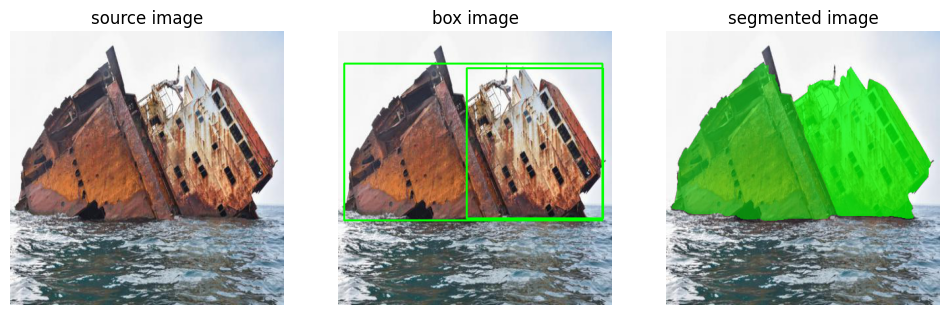

In [ ]:
### Display the images
torch.use_deterministic_algorithms(False)
masks, scores, logits = mask_predictor.predict_torch(
    point_coords = None,
    point_labels = None,
    boxes = boxes * 1040/max(img.shape),
    multimask_output=True,
)

masks = masks.cpu().numpy()

i = 0
for box in boxes.cpu().numpy():

    box_annotator = sv.BoxAnnotator(color= boxes_class_value[str(int(boxes_class[i]))], text_padding=10)
    mask_annotator = sv.MaskAnnotator(color= boxes_class_value[str(int(boxes_class[i]))])

    detections = sv.Detections(
        xyxy=sv.mask_to_xyxy(masks=masks[i]),
        mask=masks[i]
    )

    detections = detections[detections.area == np.max(detections.area)]
    box_image = box_annotator.annotate(scene=box_image, detections=detections, skip_label=True)
    segmented_image = mask_annotator.annotate(scene=segmented_image, detections=detections)
    i += 1
sv.plot_images_grid(
   images=[img,box_image, segmented_image],
   grid_size=(1, 3),
  titles=['source image','box image','segmented image']
)

## STEP 5 : Using bbunet Model

In [ ]:
# Define paths to corroded images and corresponding annotation masks
image_dir = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/train/images/"
label_dir = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/Data/train/labels/"
image_path = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(".jpg")]

In [ ]:
# Function to generate the U-Net model
def build_unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    # Decoder
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    up1 = Conv2D(64, 2, activation='relu', padding='same')(up1)
    merge1 = concatenate([conv2, up1], axis=3)

    conv4 = Conv2D(64, 3, activation='relu', padding='same')(merge1)
    conv4 = Conv2D(64, 3, activation='relu', padding='same')(conv4)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    up2 = Conv2D(32, 2, activation='relu', padding='same')(up2)
    merge2 = concatenate([conv1, up2], axis=3)

    conv5 = Conv2D(32, 3, activation='relu', padding='same')(merge2)
    conv5 = Conv2D(32, 3, activation='relu', padding='same')(conv5)

    # Output
    output = Conv2D(1, 1, activation='sigmoid')(conv5)

    model = Model(inputs=inputs, outputs=output)
    return model


In [ ]:
# Function to generate annotation masks from image coordinates
def generate_masks(image_paths, coordinates_file, input_shape):
    masks = []

    for img_path in image_paths:
        image = cv2.imread(img_path)

        # # Preprocess image as per your requirement (e.g., resizing, normalization)
        # preprocessed_image = image  # Placeholder, replace with your preprocessing steps

        # Initialize mask
        mask = np.zeros(input_shape[:2], dtype=np.uint8)

        # Read coordinates from the text file
        txt_file_path = coordinates_file + os.path.splitext(os.path.basename(img_path))[0] + '.txt'
        with open(txt_file_path, 'r') as f:
            lines = f.readlines()

        # Extract coordinates and draw polygons on the mask
        for line in lines:
            line = line.strip().split(' ')
            if len(line) == 4:
                x, y, width, height = [float(coord) for coord in line]
                x = int(x * input_shape[1])  # Scale x-coordinate to match image dimensions
                y = int(y * input_shape[0])  # Scale y-coordinate to match image dimensions
                width = int(width * input_shape[1])
                height = int(height * input_shape[0])
                cv2.rectangle(mask, (x, y), (x + width, y + height), (255, 255, 255), -1)  # Change color as required

        masks.append(mask)

    return masks

In [ ]:
# Generate annotation masks from image coordinates
masks = generate_masks(image_path, label_dir, input_shape=(224,224,3))

In [ ]:
# Convert image and mask lists to numpy arrays
images = np.array([cv2.imread(path) for path in image_path])
masks = np.array(masks)

In [ ]:
# Normalize images and masks (if required)
images = images / 255.0
masks = masks / 255.0

In [ ]:
# Split the dataset into training and validation sets
split_ratio = 0.8
split_index = int(split_ratio * len(images))
train_images, val_images = images[:split_index], images[split_index:]
train_masks, val_masks = masks[:split_index], masks[split_index:]

In [ ]:
from skimage.transform import resize

# Resize the images and masks to a consistent shape
resized_images = []
resized_masks = []
target_shape = (224, 224)  # Set the desired target shape

for image, mask in zip(train_images, train_masks):
    resized_image = resize(image, target_shape)
    resized_mask = resize(mask, target_shape)

    resized_images.append(resized_image)
    resized_masks.append(resized_mask)

resized_images = np.array(resized_images)
resized_masks = np.array(resized_masks)


In [ ]:
from skimage.transform import resize

# Resize the images and masks to a consistent shape
resized_images_val = []
resized_masks_val = []
target_shape = (224, 224)  # Set the desired target shape

for image, mask in zip(val_images, val_masks):
    resized_image_val = resize(image, target_shape)
    resized_mask_val = resize(mask, target_shape)

    resized_images_val.append(resized_image_val)
    resized_masks_val.append(resized_mask_val)

resized_images_val = np.array(resized_images_val)
resized_masks_val = np.array(resized_masks_val)


In [ ]:
# Build the U-Net model
model = build_unet_model(input_shape=(224,224,3))
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_14 (Conv2D)             (None, 224, 224, 32  896         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_15 (Conv2D)             (None, 224, 224, 32  9248        ['conv2d_14[0][0]']              
                                )                                                           

In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
### Model Compilation
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001, amsgrad= True),
                       metrics=['accuracy'])

In [ ]:
%time
### training the model
epochs=1
batch_size=32
filepath = "/content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/BBUnet Weights/BBUnet-Accuracy-Improvement-{epoch:02d}-{val_accuracy:.4f}.hdf5"
callback= ModelCheckpoint(filepath, monitor= 'val_accuracy', verbose= 1, save_best_only=True, mode= 'max')

GPU_name=tf.config.list_physical_devices('GPU')[0].name[17:]
with tf.device(device_name=GPU_name):
    model_history_1 = model.fit(resized_images, resized_masks, validation_data=(resized_images_val, resized_masks_val), epochs=epochs, batch_size=batch_size,callbacks=[callback], verbose=1)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.87 µs
13/13 [==============================] - ETA: 0s - loss: 0.1270 - accuracy: 0.9992
Epoch 1: val_accuracy improved from -inf to 1.00000, saving model to /content/drive/MyDrive/Python_DA_DS_ML/YOLO/Corrosion Detection/BBUnet Weights/BBUnet-Accuracy-Improvement-01-1.0000.hdf5
13/13 [==============================] - 41s 1s/step - loss: 0.1270 - accuracy: 0.9992 - val_loss: 1.5245e-10 - val_accuracy: 1.0000
